In [1]:
from google.colab import files
uploaded = files.upload()

Saving combined_df.csv to combined_df.csv


In [2]:
import io
import pandas as pd

df = pd.read_csv(io.BytesIO(uploaded['combined_df.csv']))

<ipython-input-2-377905b02d71>:4: DtypeWarning: Columns (21,28,33,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,91) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.BytesIO(uploaded['combined_df.csv']))


In [3]:
df

,address,categories/0,categories/1,categoryName,cid,city,countryCode,fid,imageUrl,isAdvertisement,...,visitedIn,categories/2,categories/3,categories/4,categories/5,categories/6,categories/7,categories/8,reviewContext/Reservation,categories/9
0,"122 Streatham High Rd, London SW16 1BW, United...",Portuguese restaurant,Mediterranean restaurant,Portuguese restaurant,8.714226e+18,London,GB,0x487604262fabe7a9:0x78ef26af03e86a64,https://lh3.googleusercontent.com/p/AF1QipONyX...,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"122 Streatham High Rd, London SW16 1BW, United...",Portuguese restaurant,Mediterranean restaurant,Portuguese restaurant,8.714226e+18,London,GB,0x487604262fabe7a9:0x78ef26af03e86a64,https://lh3.googleusercontent.com/p/AF1QipONyX...,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"122 Streatham High Rd, London SW16 1BW, United...",Portuguese restaurant,Mediterranean restaurant,Portuguese restaurant,8.714226e+18,London,GB,0x487604262fabe7a9:0x78ef26af03e86a64,https://lh3.googleusercontent.com/p/AF1QipONyX...,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"122 Streatham High Rd, London SW16 1BW, United...",Portuguese restaurant,Mediterranean restaurant,Portuguese restaurant,8.714226e+18,London,GB,0x487604262fabe7a9:0x78ef26af03e86a64,https://lh3.googleusercontent.com/p/AF1QipONyX...,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"122 Streatham High Rd, London SW16 1BW, United...",Portuguese restaurant,Mediterranean restaurant,Portuguese restaurant,8.714226e+18,London,GB,0x487604262fabe7a9:0x78ef26af03e86a64,https://lh3.googleusercontent.com/p/AF1QipONyX...,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8594,"5 Streatham High Rd, London SW16 1EF, United K...",Restaurant,Bar,Restaurant,3.890511e+17,London,GB,0x48760546c27a15b9:0x5662fe857610090,https://lh3.googleusercontent.com/p/AF1QipPw4M...,False,...,NaN,Brunch restaurant,Cocktail bar,Coffee shop,Coworking space,Event venue,Italian restaurant,Modern European restaurant,NaN,Pub
8595,"5 Streatham High Rd, London SW16 1EF, United K...",Restaurant,Bar,Restaurant,3.890511e+17,London,GB,0x48760546c27a15b9:0x5662fe857610090,https://lh3.googleusercontent.com/p/AF1QipPw4M...,False,...,NaN,Brunch restaurant,Cocktail bar,Coffee shop,Coworking space,Event venue,Italian restaurant,Modern European restaurant,NaN,Pub
8596,"5 Streatham High Rd, London SW16 1EF, United K...",Restaurant,Bar,Restaurant,3.890511e+17,London,GB,0x48760546c27a15b9:0x5662fe857610090,https://lh3.googleusercontent.com/p/AF1QipPw4M...,False,...,NaN,Brunch restaurant,Cocktail bar,Coffee shop,Coworking space,Event venue,Italian restaurant,Modern European restaurant,NaN,Pub
8597,"5 Streatham High Rd, London SW16 1EF, United K...",Restaurant,Bar,Restaurant,3.890511e+17,London,GB,0x48760546c27a15b9:0x5662fe857610090,https://lh3.googleusercontent.com/p/AF1QipPw4M...,False,...,NaN,Brunch restaurant,Cocktail bar,Coffee shop,Coworking space,Event venue,Italian restaurant,Modern European restaurant,NaN,Pub


In [7]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Load your data
df = pd.read_csv('combined_df.csv')

# Step 1: Create sentiment for non-null text using VADER
def classify_vader_sentiment(text):
    score = sid.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['vader_sentiment'] = df['text'].dropna().apply(classify_vader_sentiment)

# Step 2: Create sentiment proxy for null text using stars
def proxy_sentiment_from_stars(star):
    if star >= 4:
        return 'positive'
    elif star == 3:
        return 'neutral'
    elif pd.notnull(star):
        return 'negative'
    else:
        return None

df['proxy_sentiment'] = df.apply(
    lambda row: proxy_sentiment_from_stars(row['stars']) if pd.isnull(row['text']) else None,
    axis=1
)

# Step 3: Merge both into one 'final_sentiment' column
df['final_sentiment'] = df['vader_sentiment'].combine_first(df['proxy_sentiment'])

# Step 4: Group and summarize by restaurant

if 'restaurantName' not in df.columns:
    # 'title' is the actual restaurant column name
    restaurant_column_name = 'title'
else:
    restaurant_column_name = 'restaurantName'

sentiment_summary = df.groupby(restaurant_column_name)['final_sentiment'].value_counts().unstack(fill_value=0)
sentiment_summary['total'] = sentiment_summary.sum(axis=1)
sentiment_summary['positive_ratio'] = sentiment_summary['positive'] / sentiment_summary['total']

# Sort restaurants by positivity
sentiment_summary_sorted = sentiment_summary.sort_values(by='positive_ratio', ascending=False)

# Display result
print(sentiment_summary_sorted)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
<ipython-input-7-a37bb79665f0>:10: DtypeWarning: Columns (21,28,33,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,91) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('combined_df.csv')


final_sentiment                      negative  neutral  positive  total  \
title                                                                     
Roots Restaurant                           19       24       693    736   
Paratha Inn (Streatham)                     7       13       291    311   
SW16 Bar & Kitchen                         27       25       677    729   
Italian Bistro (Italian Restaurant)        32       41       772    845   
Putt Putt & Karaoke Bar                    58       40       693    791   
La Casita                                  45      106       785    936   
Slurp                                      67       73       649    789   
Porky's Wine Bar                           33       57       341    431   
Nando's Streatham                         144      192      1097   1433   
Starbucks Coffee                           60       43       302    405   
Marinatto                                  31       94       309    434   
KFC London               

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
<ipython-input-8-21a45b5a6ec8>:11: DtypeWarning: Columns (21,28,33,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,91) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('combined_df.csv')


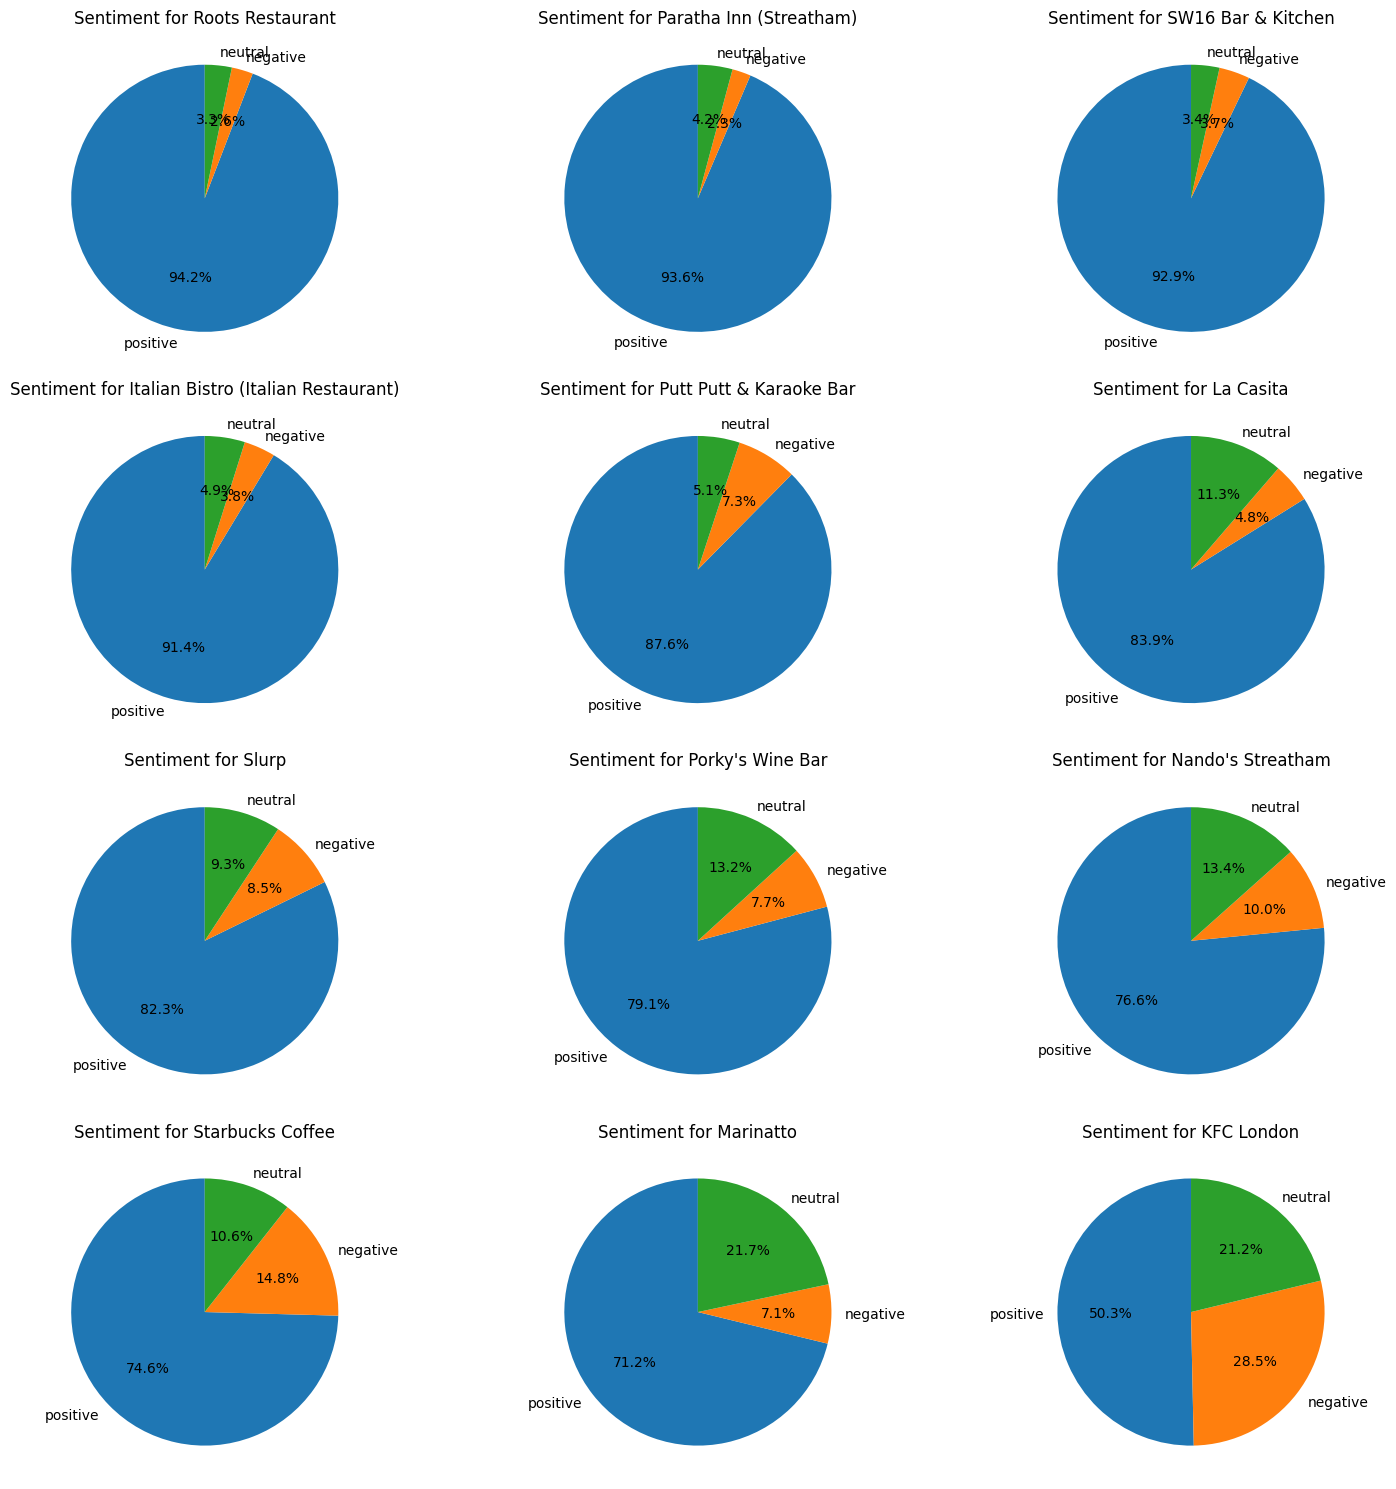

In [8]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import matplotlib.pyplot as plt

# Download VADER lexicon
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Load your data
df = pd.read_csv('combined_df.csv')

# Create pie charts for each restaurant in a 4x3 subplot
fig, axes = plt.subplots(4, 3, figsize=(15, 15))  # Create a 4x3 grid of subplots
axes = axes.flatten()  # Flatten the axes array for easier iteration

for i, (restaurant, data) in enumerate(sentiment_summary_sorted.iterrows()):
    # Get sentiment counts for the current restaurant
    sentiment_counts = data[['positive', 'negative', 'neutral']]

    # Create pie chart in the current subplot
    axes[i].pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'Sentiment for {restaurant}')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

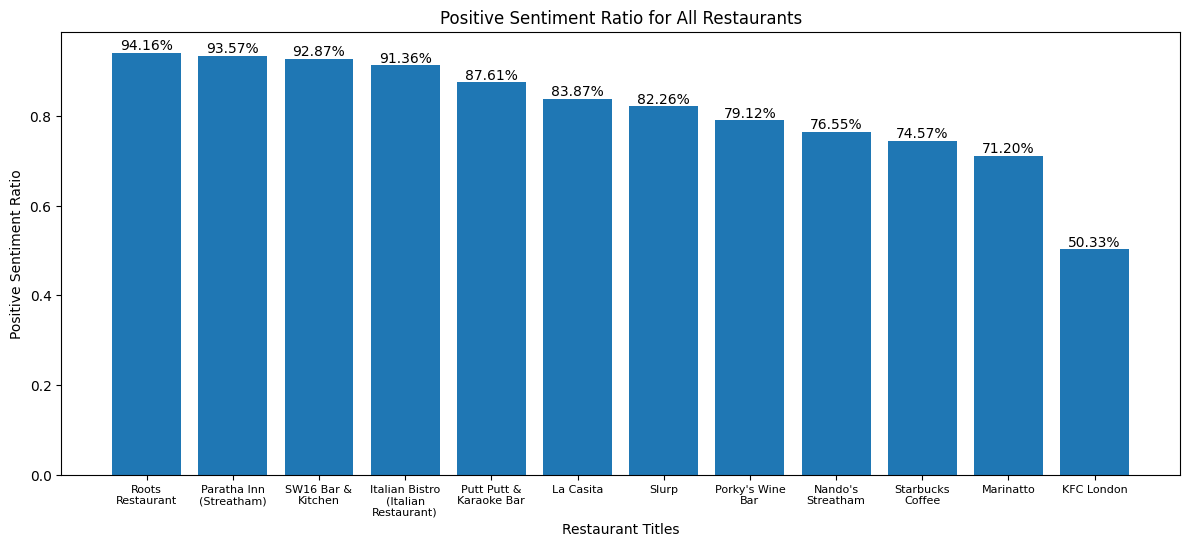

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from textwrap import wrap

# Create a bar chart
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
bars = plt.bar(sentiment_summary_sorted.index, sentiment_summary_sorted['positive_ratio'])
plt.xlabel('Restaurant Titles')
plt.ylabel('Positive Sentiment Ratio')
plt.title('Positive Sentiment Ratio for All Restaurants')

# Add positive_ratio on top of each bar
for i, bar in enumerate(bars):  # Enumerate bars to get their index
    height = bar.get_height()
    restaurant_name = sentiment_summary_sorted.index[i]  # Get restaurant name using index
    positive_ratio = sentiment_summary_sorted.loc[restaurant_name, "positive_ratio"]  # Access positive_ratio using restaurant name
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{positive_ratio:.2%}',  # Format as percentage with 2 decimal places
             ha='center', va='bottom')

# Split x-axis labels into two lines and wrap text
labels = sentiment_summary_sorted.index
wrapped_labels = ['\n'.join(wrap(label, 15)) for label in labels]  # Wrap text to 15 characters

# Adjust x-axis tick positions and labels
plt.xticks(np.arange(len(labels)), wrapped_labels, rotation=0, ha='center', fontsize=8) # Rotate and adjust font size

plt.tight_layout()
plt.subplots_adjust(bottom=0.2) # Adjust bottom margin for x-axis labels
plt.show()

VADER Scores: {'neg': 0.0, 'neu': 0.552, 'pos': 0.448, 'compound': 0.9519}


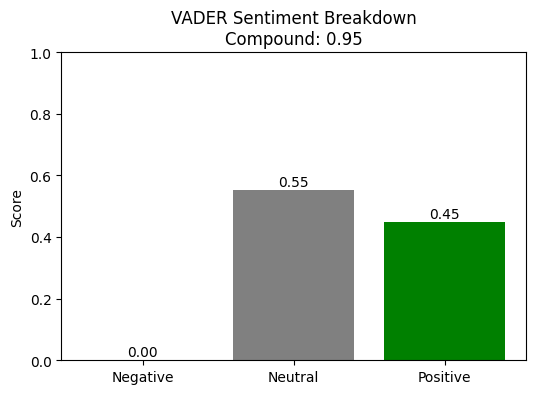

In [21]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Initialize VADER
sid = SentimentIntensityAnalyzer()

# Choose an individual review
sample_text = df['text'].dropna().iloc[0]  # first non-null review

# Get VADER scores
scores = sid.polarity_scores(sample_text)
print("VADER Scores:", scores)

# Bar chart to visualize the decision
labels = ['Negative', 'Neutral', 'Positive']
values = [scores['neg'], scores['neu'], scores['pos']]

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, values, color=['red', 'gray', 'green']) # Assign the bars to a variable
plt.title(f"VADER Sentiment Breakdown\nCompound: {scores['compound']:.2f}")
plt.ylabel('Score')
plt.ylim(0, 1)

# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + .005, '{:.2f}'.format(yval), ha='center', va='bottom')

plt.show()

VADER Scores: {'neg': 0.0, 'neu': 0.205, 'pos': 0.795, 'compound': 0.5974}


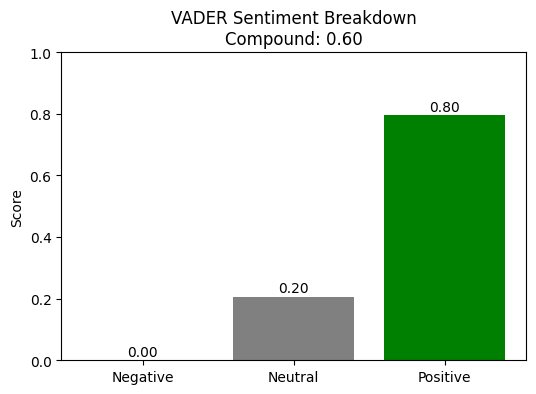

In [22]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Initialize VADER
sid = SentimentIntensityAnalyzer()

# Choose an individual review
sample_text = df['text'].dropna().iloc[3022]  # first non-null review

# Get VADER scores
scores = sid.polarity_scores(sample_text)
print("VADER Scores:", scores)

# Bar chart to visualize the decision
labels = ['Negative', 'Neutral', 'Positive']
values = [scores['neg'], scores['neu'], scores['pos']]

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, values, color=['red', 'gray', 'green']) # Assign the bars to a variable
plt.title(f"VADER Sentiment Breakdown\nCompound: {scores['compound']:.2f}")
plt.ylabel('Score')
plt.ylim(0, 1)

# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + .005, '{:.2f}'.format(yval), ha='center', va='bottom')

plt.show()

VADER Scores: {'neg': 0.0, 'neu': 0.542, 'pos': 0.458, 'compound': 0.9509}


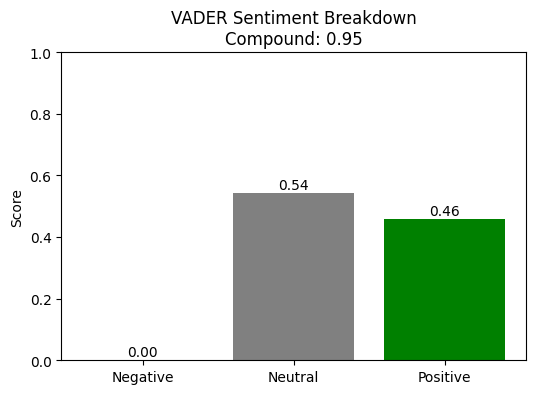

In [25]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Initialize VADER
sid = SentimentIntensityAnalyzer()

# Choose an individual review
sample_text = df['text'].dropna().iloc[4612]  # first non-null review

# Get VADER scores
scores = sid.polarity_scores(sample_text)
print("VADER Scores:", scores)

# Bar chart to visualize the decision
labels = ['Negative', 'Neutral', 'Positive']
values = [scores['neg'], scores['neu'], scores['pos']]

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, values, color=['red', 'gray', 'green']) # Assign the bars to a variable
plt.title(f"VADER Sentiment Breakdown\nCompound: {scores['compound']:.2f}")
plt.ylabel('Score')
plt.ylim(0, 1)

# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + .005, '{:.2f}'.format(yval), ha='center', va='bottom')

plt.show()

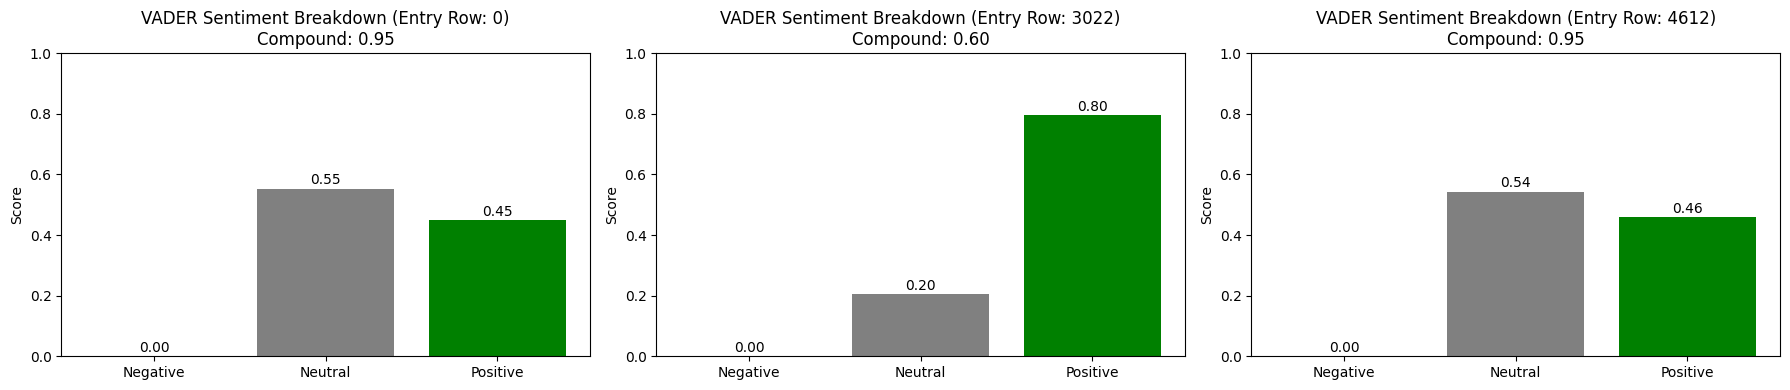

In [27]:
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize VADER
sid = SentimentIntensityAnalyzer()

# Choose the individual reviews with their row indices
sample_texts_with_indices = [
    (df['text'].dropna().iloc[0], 0),  # First review, index 0
    (df['text'].dropna().iloc[3022], 3022),  # Second review, index 3022
    (df['text'].dropna().iloc[4612], 4612)  # Third review, index 4612
]

# Create a 1x3 subplot
fig, axes = plt.subplots(1, 3, figsize=(18, 4))  # Adjust figsize as needed

# Iterate through the reviews and create visualizations
for i, (sample_text, row_index) in enumerate(sample_texts_with_indices):
    scores = sid.polarity_scores(sample_text)
    labels = ['Negative', 'Neutral', 'Positive']
    values = [scores['neg'], scores['neu'], scores['pos']]

    # Create bar chart in the current subplot
    bars = axes[i].bar(labels, values, color=['red', 'gray', 'green'])
    axes[i].set_title(f"VADER Sentiment Breakdown (Entry Row: {row_index})\nCompound: {scores['compound']:.2f}")
    axes[i].set_ylabel('Score')
    axes[i].set_ylim(0, 1)

    # Add values on top of bars
    for bar in bars:
        yval = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width() / 2, yval + .005,
                     '{:.2f}'.format(yval), ha='center', va='bottom')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()